# Mean field correlation dynamics for noisy signal propagation

In [1]:
# imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.collections import LineCollection

# custom imports
# from src.simulation import *
from src.numpy_simulation import *
from src.utils import load_experiment
from src.viz import get_colours
from src.theory import fixed_point
from src.theory import c_map_slope
from src.theory import c_map
from src.theory import depth_scale

# plot settings
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

## --- Correlation map: Theory vs simulation ---

In [ ]:
# Compute experimental data
experiments = [
    {"dist": "none", "noise": (None, None), "act":"relu", "init":"crit"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"crit"}, 
    {"dist": "bern", "noise": ('prob_1', 0.8), "act":"relu", "init":"crit"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"crit"}, 
    {"dist": "mult gauss", "noise": ('std', 2), "act":"relu", "init":"crit"}
]

# run experiments
for experiment in experiments:
    dist = experiment['dist']
    noise = experiment['noise']
    act = experiment['act']
    init = experiment['init']
    
    # run simulations for scenario
    noisy_signal_prop_simulations(dist, noise, act, init)

### Iterative correlation map and correlation dynamics

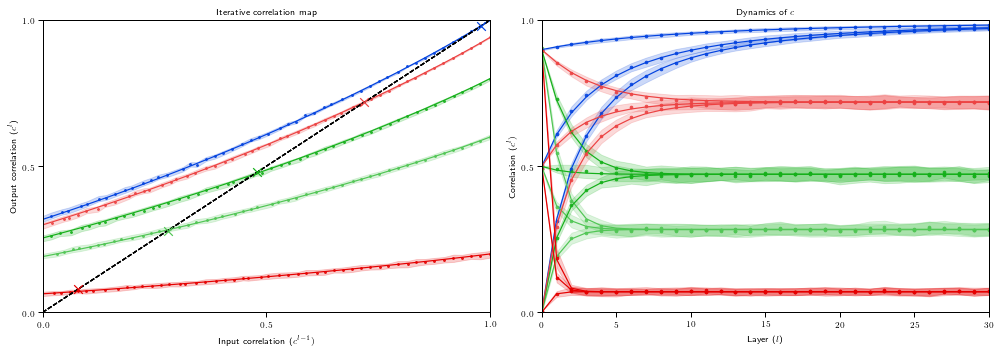

In [2]:
tests = [{
        "distributions": [{"dist": "none"}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.8}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 2}],
        "activations": ["relu"],
        "inits": ["crit"]
    }]


fig = plt.figure(figsize=(14, 5))
pal = get_colours(10, 7)
gs = plt.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, 
                                      ["multi_layer_cmap_sim", "cmap", "ctrajs", "chi1", "cmap_sim"], "results"))

for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        if dist['dist'] == "none":
            col_i = 0
            shade_i = 6
        elif dist['dist'] == "bern":
            col_i = 1

            if float(dist['prob_1']) < 0.7:
                shade_i = 4
            else:
                shade_i = 6

        elif "gauss" in dist['dist']:
            col_i = 3

            if float(dist['std']) < 0.5:
                shade_i = 4
            else:
                shade_i = 6

        for act in attr["activations"]:
            for init in attr["inits"]:
                correlations = test[dist['dist']][act][init]['multi_layer_cmap_sim']
                cmap_data = test[dist['dist']][act][init]['cmap']
                cmaps = cmap_data["cmaps"]
                cstars = cmap_data["cstars"]
                ctrajs = test[dist['dist']][act][init]['ctrajs']
                cmap_sim_data = test[dist['dist']][act][init]['cmap_sim']
                cmap_sim_input = cmap_sim_data["input_correlations"]
                cmap_sim_output = cmap_sim_data["output_correlations"]

                num_trials = cmap_sim_input.shape[0]
                num_networks = cmap_sim_output.shape[0] // num_trials
                
                # create label
                label = ""

                try:
                    label = "$\sigma_\epsilon = $ " + str(dist['std'])
                except:
                    try:
                        label ="$p = $ " + str(dist['prob_1'])
                    except:
                        pass
                    # except:
                    #     label = dist_name

                ############################################################
                # left
                ############################################################
                crange = np.linspace(0, 1.0, 51)

                # Theory
                ax1.plot(crange, cmaps[0, 0], c=pal[col_i][shade_i], label=label)

                # Simulation
                mu_x = cmap_sim_input.mean(axis=0)
                mu_y = cmap_sim_output.mean(axis=0).mean(axis=0)
                std_y = cmap_sim_output.mean(axis=1).std(axis=0)

                ax1.scatter(mu_x, mu_y, marker="o", s=4, alpha=0.9, color=pal[col_i][shade_i])
                ax1.fill_between(mu_x, mu_y - std_y, mu_y + std_y, alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

                # Add unity line
                ax1.plot((0, 1), (0, 1), '--', color='k', zorder=900)
                ax1.set_xlim(0, 1)
                ax1.set_ylim(0, 1)
                # ax3.axis('tight')

                ax1.scatter(cstars[0, 0], cstars[0, 0], s=75, marker= 'x', c=pal[col_i][shade_i], zorder=999, alpha=1.0, clip_on=False)

                ax1.set_title(r'Iterative correlation map')

                ############################################################
                # right - dynamics of convergence
                ############################################################
                # Theory
                for j in range(correlations.shape[0]):
                    ax2.plot(ctrajs[0, 0, j, :].T, c=pal[col_i][shade_i])


                # Simulations
                x_axis = np.arange(0, correlations.shape[-1])

                means = correlations.mean(axis=-2).mean(axis=-2)
                std = correlations.mean(axis=-2).std(axis=-2)

                for i in np.arange(means.shape[0]):
                    ax2.scatter(np.arange(means[i].shape[0]), means[i], marker='o', s=8, alpha=0.9, color=pal[col_i][shade_i])
                    ax2.fill_between(x_axis, means[i] - std[i], means[i] + std[i], alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

ax1.set_xticks([0, 0.5, 1.0])
ax1.set_yticks([0, 0.5, 1.0])
ax1.set_xlabel('Input correlation ($c^{l-1})$')
ax1.set_ylabel('Output correlation ($c^{l}$)')

ax2.set_xlabel('Layer ($l$)')
ax2.set_ylabel('Correlation ($c^{l})$')
ax2.set_title('Dynamics of $c$')
ax2.set_yticks([0, 0.5, 1])
ax2.set_ylim(0, 1)
ax2.set_xlim(0, correlations.shape[-1] - 1)
# plt.show()
plt.gcf().tight_layout()
plt.savefig("correlation.pdf")

## --- Slope at correlation fixed point ---

In [ ]:
# rates = np.linspace(0.1, 1, 100)
# mu2s = 1/rates
# fps = []
# fp_slopes = []
# for p in rates:
#     mu2 = 1/p
#     fpoint = fixed_point(c_map, p, p*2, mu2)
#     fps.append(fpoint)

#     slope = c_map_slope(fpoint, p*2)
#     fp_slopes.append(slope)

# plt.plot(mu2s, fp_slopes, c='purple', label="Noise critical initialisation")
# plt.xlabel("Second moment of noise distribution ($\mu_2$)")
# plt.ylabel("Slope at fixed point $c^*$")
# plt.scatter(1, 1, c="red", marker='*', label='Edge of chaos', s=100)
# plt.fill_between(mu2s, 0, 1, facecolor='cyan', alpha=0.2)
# plt.text(3, 0.5, 'Ordered regime \n (vanishing gradients)', fontsize=12)
# plt.legend()
# plt.xlim(0.8, 10)
# plt.ylim(0, 1.05)
# plt.title('Phase diagram')
# plt.gcf().tight_layout()
# plt.show()

## --- Performance depths scales at criticality --- 

In [ ]:
# fig, ax = plt.subplots()
# pickle_in = open("src/results/val_loss_per_depth.pk","rb")
# example_dict = np.array(pickle.load(pickle_in))[:,1]
# rates = np.linspace(0.1, 1, 100)

# nets = np.linspace(2, 40, 10, dtype=int)
# d_rates = 2*np.linspace(0.1, 1, 10)
# xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

# Z1 = np.array(example_dict)
# pcm = plt.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r')
# cbar1 = fig.colorbar(pcm, ax=ax, extend='max')
# cbar1.ax.set_title('Val. loss')

# # Now do a second plot coloring the curve using a continuous colormap
# t = rates #np.linspace(0, 10, 200)
# x = 2*rates
# y = 6*depth_scale(fp_slopes)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
# lc.set_array(t)
# lc.set_linewidth(3)
# cbar2 = fig.colorbar(lc, ax=ax)
# cbar2.ax.set_title('p')

# ax.add_collection(lc)
# plt.xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
# plt.ylabel("Number of layers")
# plt.text(1.5, 19, r'$6\xi_c$', fontsize=12, color="white")
# plt.title("Depth at criticality")
# plt.xlim(0.3, 2.1)
# plt.ylim(2, 40)
# plt.legend(loc=(0.1, 0.65))
# plt.gcf().tight_layout()
# plt.show()

/Users/elanvanbiljon/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:206: RuntimeWarning: divide by zero encountered in log10
  ret_val[shrinking_ps] = (np.log10(shrink_value) - np.log10(q_0))/np.log10(growth_rate[shrinking_ps])
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:249: RuntimeWarning: divide by zero encountered in true_divide
  return -1/(np.log(xi))


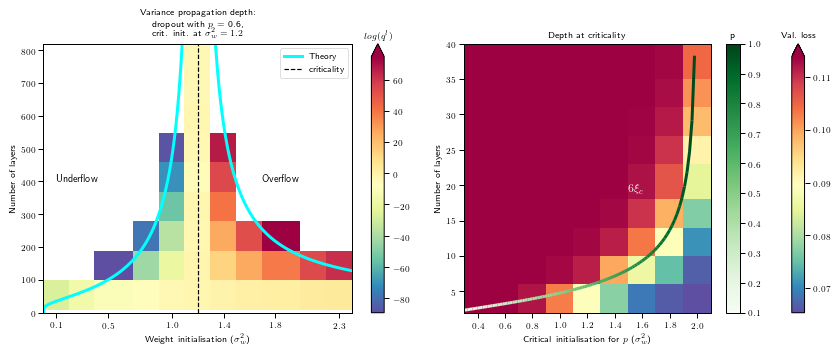

In [3]:
rates = np.linspace(0.1, 1, 100)
mu2s = 1/rates
fps = []
fp_slopes = []
for p in rates:
    mu2 = 1/p
    fpoint = fixed_point(c_map, p, p*2, mu2)
    fps.append(fpoint)

    slope = c_map_slope(fpoint, p*2)
    fp_slopes.append(slope)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
pickle_in = open("src/results/under_overflow.pk","rb")
example_dict = pickle.load(pickle_in)[:120]
p = 0.6
num_layers = 1000
nets = np.linspace(10, num_layers, 12, dtype=int)[:10]
inits = np.round(np.linspace(0.1, 2.5, 12),1)
xv, yv = np.meshgrid(nets, inits, sparse=False, indexing='ij')

Z1 = np.log(np.array(example_dict))

bad_indices = np.isnan(Z1) + np.isinf(Z1)
Z1 = np.ma.array(Z1, mask=bad_indices)
cmap = matplotlib.cm.get_cmap(name="Spectral_r")
cmap.set_bad('white', 1.)

pcm = ax1.pcolormesh(yv-0.1, xv-0.1, Z1.reshape(10,12), cmap=cmap)
cbar = fig.colorbar(pcm, ax=ax1, extend='max')
cbar.ax.set_title('$log(q^l)$')

ax1.set_xlabel('Weight initialisation ($\sigma^2_w$)')

ax1.set_ylabel("Number of layers")
ax1.set_title("Variance propagation depth:\ndropout with $p$ = 0.6,\ncrit. init. at $\sigma^2_w = 1.2$")

max_depth = 0
init_theory = np.linspace(0, 2.4, 1000)
depth_per_p_theory = depth("Dropout", init_theory, p)
max_depth = np.max([max_depth, np.max(depth_per_p_theory)])
ax1.plot(init_theory, depth_per_p_theory, label="Theory", c='cyan', linewidth=3)

# plot critical point
crit_point = critical_point("Dropout", p)
ax1.plot([crit_point,]*2, [0, num_layers], color="black", linestyle="--", label="criticality")

ax1.set_ylim(0, 820)
ax1.legend()
ax1.set_xticks(inits[:-1:2])
ax1.text(0.1, 400, 'Underflow', fontsize=10)
ax1.text(1.7, 400, 'Overflow', fontsize=10)

pickle_in = open("src/results/val_loss_per_depth.pk","rb")
example_dict = np.array(pickle.load(pickle_in))[:,1]
rates = np.linspace(0.1, 1, 100)

nets = np.linspace(2, 40, 10, dtype=int)
d_rates = 2*np.linspace(0.1, 1, 10)
xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

Z1 = np.array(example_dict)
pcm = ax2.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r')
cbar1 = fig.colorbar(pcm, ax=ax2, extend='max')
cbar1.ax.set_title('Val. loss')

# Now do a second plot coloring the curve using a continuous colormap
t = rates #np.linspace(0, 10, 200)
x = 2*rates
y = 6*depth_scale(fp_slopes)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
lc.set_array(t)
lc.set_linewidth(3)
cbar2 = fig.colorbar(lc, ax=ax2)
cbar2.ax.set_title('p')

ax2.add_collection(lc)
ax2.set_xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
ax2.set_ylabel("Number of layers")
ax2.text(1.5, 19, r'$6\xi_c$', fontsize=12, color="white")
ax2.set_title("Depth at criticality")
ax2.set_xlim(0.3, 2.1)
ax2.set_ylim(2, 40)
# ax2.legend(loc=(0.1, 0.65))
# plt.show()
plt.gcf().tight_layout()
plt.savefig("depth_scales.pdf")

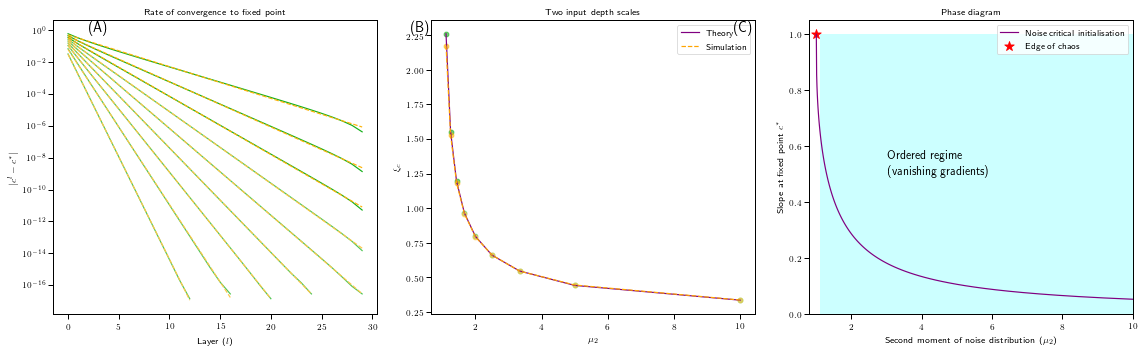

In [4]:
tests = [{
        "distributions": [{"dist": "bern", "prob_1": 0.1}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.2}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.3}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.4}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.5}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.7}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.8}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.9}],
        "activations": ["relu"],
        "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.1}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.25}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.4}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.55}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.7}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 0.85}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.0}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.15}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.3}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.45}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.6}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.75}],
#         "activations": ["relu"],
#         "inits": ["crit"]
#     }, {
#         "distributions": [{"dist": "mult gauss", "std": 1.9}],
#         "activations": ["relu"],
#         "inits": ["crit"]
    }]


fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(hspace=0.4)
pal = get_colours(10, 7)
gs = plt.GridSpec(1, 3)
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 0])
ax5 = plt.subplot(gs[0, 1])
cols_shades = []

c_stars = []
mu2s = []
inferred_xi = []

test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, 
                                      ["multi_layer_cmap_sim", "cmap", "ctrajs", "chi1", "cmap_sim"], "results"))

for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        if dist['dist'] == "none":
            col_i = 0
            shade_i = 6
        elif dist['dist'] == "bern":
            col_i = 1
            mu2s.append(1/float(dist['prob_1']))

            if float(dist['prob_1']) < 0.7:
                shade_i = 4
            else:
                shade_i = 6

        elif "gauss" in dist['dist']:
            col_i = 3
            mu2s.append(float(dist['std'])**2 + 1)

            if float(dist['std']) < 0.5:
                shade_i = 4
            else:
                shade_i = 6
        cols_shades.append([col_i, shade_i])

        for act in attr["activations"]:
            for init in attr["inits"]:
                correlations = test[dist['dist']][act][init]['multi_layer_cmap_sim']
                cmap_data = test[dist['dist']][act][init]['cmap']
                cmaps = cmap_data["cmaps"]
                cstars = cmap_data["cstars"]
                ctrajs = test[dist['dist']][act][init]['ctrajs']
                cmap_sim_data = test[dist['dist']][act][init]['cmap_sim']
                cmap_sim_input = cmap_sim_data["input_correlations"]
                cmap_sim_output = cmap_sim_data["output_correlations"]

                # create label
                label = ""

                try:
                    label = "Gauss: $\sigma_\epsilon = $ " + str(dist['std'])
                except:
                    try:
                        label = "Dropout: $p = $ " + str(dist['prob_1'])
                    except:
                        label = "No noise"

                c_stars.append(correlations.mean(axis=-2).mean(axis=-2).mean(axis=0)[-1])

                #############
                # SEE HERE! #
                #############
                    
                # plot rates of convergence
                rates = np.abs(ctrajs[0, 0, 0, :].T - ctrajs[0, 0, 0, -1])
                
                # mask zero values so that they don't break the plot
                rates = np.ma.array(rates, mask=(rates == 0))
                ax4.plot(rates, c=pal[col_i][shade_i])
                
                # get a axis that corresponds to the non-zero elements
                non_masked = np.array(np.ma.getmask(rates) ^ 1, dtype=bool)
                x = np.arange(rates.shape[0])[non_masked]
    
                z, b = np.polyfit(x, np.log(rates[x]), 1)
                return_value = np.polyfit(x, np.log(rates[x]), 1)
                ax4.plot(x, np.exp(x*z + b), c=pal[col_i+1][shade_i], linestyle="--")
                inferred_xi.append(-1/z)
    

####################################
# Slope at correlation fixed point #
####################################

rates = np.linspace(0.1, 1, 100)
_mu2s = 1/rates
fps = []
fp_slopes = []
for p in rates:
    mu2 = 1/p
    fpoint = fixed_point(c_map, p, p*2, mu2)
    fps.append(fpoint)

    slope = c_map_slope(fpoint, p*2)
    fp_slopes.append(slope)

ax3.plot(_mu2s, fp_slopes, c='purple', label="Noise critical initialisation")
ax3.set_xlabel("Second moment of noise distribution ($\mu_2$)")
ax3.set_ylabel("Slope at fixed point $c^*$")
ax3.scatter(1, 1, c="red", marker='*', label='Edge of chaos', s=100)
ax3.fill_between(mu2s, 0, 1, facecolor='cyan', alpha=0.2)
ax3.text(3, 0.5, 'Ordered regime \n (vanishing gradients)', fontsize=12)
ax3.legend()
ax3.set_xlim(0.8, 10)
ax3.set_ylim(0, 1.05)
ax3.set_title('Phase diagram')

###############
# D SEE HERE! #
###############
ax4.set_yscale('log')
ax4.set_ylabel(r'$|c^l - c^*|$')
ax4.set_xlabel('Layer ($l$)')
ax4.set_title('Rate of convergence to fixed point')

###############
# E SEE HERE! #
###############

c_stars = np.array(c_stars)
mu2s = np.array(mu2s)
inferred_xi = np.array(inferred_xi)

# compare theory depth scales with inferred ones from simulations
xi_c = -1/np.log(np.arcsin(c_stars)/(np.pi*mu2s) + 1/(2*mu2s))

for col_shade, mu2, xi, inf_xi in zip(cols_shades, mu2s, xi_c, inferred_xi):
    col = col_shade[0]
    shade = col_shade[1]
    ax5.plot(mu2, xi, 'ro', c=pal[col][shade], alpha=0.6)
    ax5.plot(mu2, inf_xi, 'ro', c=pal[col+1][shade], alpha=0.6)
    
mu2s_line = np.sort(mu2s)
xi_c_line = np.flip(np.sort(xi_c), axis=0)
inf_xi_line = np.flip(np.sort(inferred_xi), axis=0)
ax5.plot(mu2s_line, xi_c_line, label='Theory', c='purple')
ax5.plot(mu2s_line, inf_xi_line, linestyle='--', label='Simulation', c='orange')
ax5.set_ylabel(r'$\xi_c$')
ax5.set_xlabel(r'$\mu_2$')
ax5.set_title("Two input depth scales")
ax5.legend()

##############
# add labels #
##############
fig.text(0.08, 0.9, "(A)", fontsize=14)
fig.text(0.36, 0.9, "(B)", fontsize=14)
fig.text(0.64, 0.9, "(C)", fontsize=14)


# plt.savefig('corrplot.pdf', dpi=200)
# plt.show()
plt.gcf().tight_layout()
plt.savefig("xi.pdf")